In [160]:
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from matplotlib import pyplot as plt #for visualizing 

# #Trainer Imports
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

#From the local python files
from datasets_denoising import DenoisingPairedDataset
from trainer_denoising import DenoisingTrainer
from trainer_denoising import perceptual_loss, combined_loss, DenoisingTrainer
from models_denoising import DenoisingCNN, DenoisingUNet, ImprovedDenoisingUNet, ResidualUNet, MotionAwareDenoiser

from losses import SSIMLoss, CombinedLoss



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Root directories

In [178]:
root_dir = 'aquarium_pretrain'

splits = ['train', 'test','valid']

model_path = '/home/ubuntu/cs230_VIVEKA/saved_models'

# Main model training pipeline

##### create datasets, dataloaders, model, trainer

In [179]:
hyperparams = ['batch_size', 'lr', 'num_epochs', 'dropout_rate']
batch_size = 32
num_epochs = 30
lr = 1e-3


In [180]:
#Transforms
transform_regular = T.ToTensor()

transform_resize = T.Compose( [ T.Resize((224,224)) , T.ToTensor() ] ) #IMPORTANT: size is taken from datasets.py transform in order to match 

create dataset

In [164]:
#Dataset creation with default x_path and y_path.
train_data = DenoisingPairedDataset(root_dir=root_dir, split='train', transform=transform_resize) 
valid_data = DenoisingPairedDataset(root_dir=root_dir, split='valid', transform=transform_resize)
test_data = DenoisingPairedDataset(root_dir=root_dir, split='test', transform=transform_resize)

create DataLoaders

In [165]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

create Model, device

In [181]:
#define models
model_simple = DenoisingCNN()
model_unet = DenoisingUNet()
model_unet_improved = ImprovedDenoisingUNet()
model_residual_unet = ResidualUNet()
model_motionaware = MotionAwareDenoiser()

In [182]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [183]:
model = model_residual_unet #Edit model here

model.to(device)
#criterion = nn.MSELoss()
criterion = CombinedLoss(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)


In [184]:
#Save model and loss specifications
modelName = str(model).split('(')[0]
modelLoss = str(criterion).split('(')[0]

save_filename = 'model_weights.pth'
save_folder = modelName + '_' + modelLoss

os.makedirs( os.path.join('saved_models',save_folder) , exist_ok=True)

save_path = os.path.join('saved_models', save_folder, save_filename)

print(f"Model {modelName} with loss {modelLoss} will be saved to: {save_path}")

Model ResidualUNet with loss CombinedLoss will be saved to: saved_models/ResidualUNet_CombinedLoss/model_weights.pth


In [185]:
trainer = DenoisingTrainer(model, device, criterion, optimizer, save_path=save_path)

##### Train model

Epoch 1/10, Training Loss: 0.7018
Epoch 1/10, Validation Loss: 0.5173
Model saved with validation loss: 0.5173
Epoch 2/10, Training Loss: 0.4132
Epoch 2/10, Validation Loss: 0.3494
Model saved with validation loss: 0.3494
Epoch 3/10, Training Loss: 0.3105
Epoch 3/10, Validation Loss: 0.2827
Model saved with validation loss: 0.2827
Epoch 4/10, Training Loss: 0.2639
Epoch 4/10, Validation Loss: 0.2426
Model saved with validation loss: 0.2426
Epoch 5/10, Training Loss: 0.2331
Epoch 5/10, Validation Loss: 0.2145
Model saved with validation loss: 0.2145
Epoch 6/10, Training Loss: 0.2068
Epoch 6/10, Validation Loss: 0.1922
Model saved with validation loss: 0.1922
Epoch 7/10, Training Loss: 0.1879
Epoch 7/10, Validation Loss: 0.1747
Model saved with validation loss: 0.1747
Epoch 8/10, Training Loss: 0.1730
Epoch 8/10, Validation Loss: 0.1635
Model saved with validation loss: 0.1635
Epoch 9/10, Training Loss: 0.1652
Epoch 9/10, Validation Loss: 0.1548
Model saved with validation loss: 0.1548
E

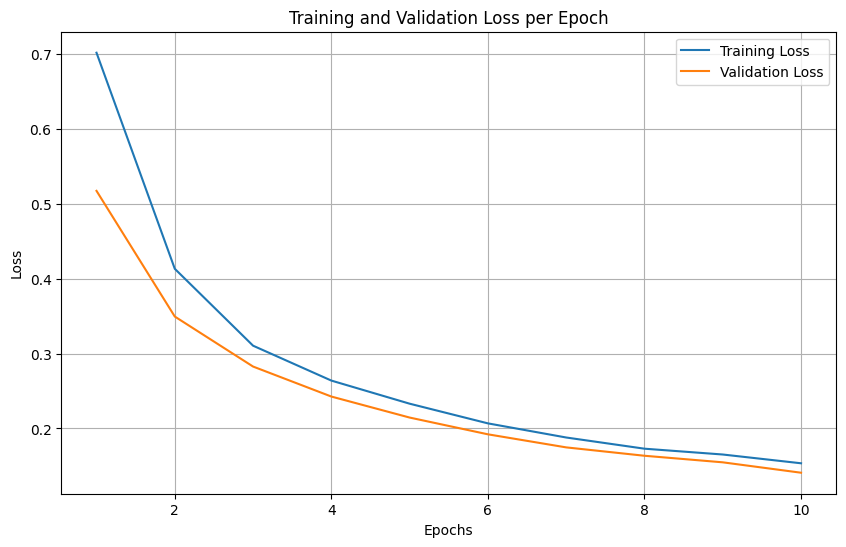

In [186]:
trainer.train(train_loader, valid_loader, num_epochs=10)

##### Evaluate model

In [187]:
val_loss, val_psnr, val_ssim = trainer.evaluate(valid_loader)
#print(f"Validation - Loss: {val_loss:.4f}, PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")

test_loss, test_psnr, test_ssim = trainer.evaluate(test_loader)
#print(f"Test - Loss: {test_loss:.4f}, PSNR: {test_psnr:.4f}, SSIM: {test_ssim:.4f}")


Avg Loss: 0.1409, Avg PSNR: 20.4176, Avg SSIM: 0.7194
Avg Loss: 0.1565, Avg PSNR: 20.1550, Avg SSIM: 0.7283


# visualize dataset, model outputs

#### visualization functions

In [188]:
def unnormalize(img_tensor, mean, std):
    """
    Unnormalize a tensor image given the original mean and standard deviation.
    """
    img_tensor = img_tensor.clone().detach().cpu()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

In [150]:
def visualize_output(model, data, device, idx, normalize=True, normalization_mean=[0.5, 0.5, 0.5], normalization_std=[0.5,0.5,0.5]):
    ''' Plots the input, ground truth, and model output of a given ID in the dataset. 
        ID must be within (0, len(dataset)). 
        Unnormalizes the image if
    '''
    if idx >= len(data): raise IndexError("idx out of bounds of dataset length")

    noisy_image, clean_image = data[idx] 
    noisy_image = noisy_image.unsqueeze(0).to(device)
    filename = data.get_filename(idx)
    
    with torch.no_grad():
        predicted_image = model(noisy_image).cpu().squeeze(0) #create predicted image from model 

    if normalize: #removes normalization on the dataset images if it was applied in a transform; normalization_mean and std are static/fixed as of now and defined earlier in the notebook
        noisy_image = unnormalize(noisy_image.cpu().squeeze(0), normalization_mean, normalization_std)
        clean_image = unnormalize(clean_image, normalization_mean, normalization_std)
    else:
        noisy_image = noisy_image.cpu().squeeze(0) #if no normalization for noisy_image
    
    predicted_image = predicted_image.permute(1, 2, 0).clip(0, 1)  # Transpose for plotting
    
    print(filename)
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Filename: {filename}", fontsize=16)
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_image.permute(1, 2, 0))
    plt.title("Noisy Input")
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image)
    plt.title("Model Output")
    plt.subplot(1, 3, 3)
    plt.imshow(clean_image.permute(1, 2, 0))
    plt.title("Ground Truth")
    plt.show()

#### visualize

In [191]:
model_path = save_path
#model_path = 'saved_models/DenoisingUNet_CombinedLoss/model_weights.pth'
model_vis = model
model_vis.load_state_dict(torch.load(model_path))
model_vis.eval()
model_vis.to(device)

/tmp/ipykernel_2611/3347638998.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vis.load_state_dict(torch.load(model_path))


ResidualUNet(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (dec_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
  )
  (dec_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
  )
  (final_conv): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

IMG_3142_jpeg_jpg.rf.a6c10fb5c976d1f187eea2ee29fd7fe0.jpg


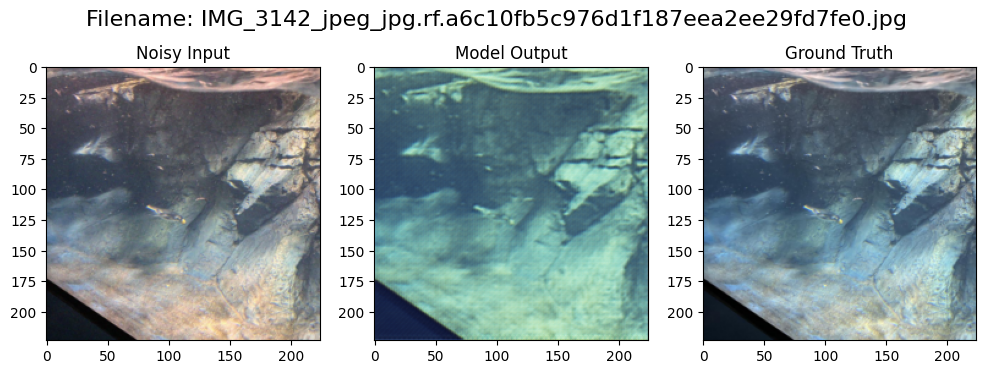

In [196]:
visualize_output(model=model_vis, data=train_data, device=device, idx=50, normalize=False)

#### Visualize model architecture.

In [211]:
import torch
import torchviz

In [219]:
input = next(iter(train_data))[0].unsqueeze(0)

In [220]:
input.shape

torch.Size([1, 3, 224, 224])